# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import wikipedia
from fuzzywuzzy import fuzz
import itertools
from fuzzywuzzy import process
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

In [2]:
all_crawling_data =  pd.read_csv('../data/all_crawling_data.csv')

In [3]:
all_crawling_data.head()

,home_FG,home_FGA,home_3P,home_3PA,home_FT,home_FTA,home_ORB,home_TRB,home_AST,home_STL,home_BLK,home_TOV,home_PF,home_PTS,away_FG,away_FGA,away_3P,away_3PA,away_FT,away_FTA,away_ORB,away_TRB,away_AST,away_STL,away_BLK,away_TOV,away_PF,away_PTS,start_time,away_team,home_team,away_team_score,home_team_score,phase,Tournament
0,22.0,59.0,7.0,24.0,11.0,25.0,14.0,40.0,14.0,9.0,4.0,22.0,25.0,62.0,20.0,54.0,5.0,25.0,12.0,21.0,4.0,27.0,13.0,8.0,0.0,21.0,26.0,57.0,2014-10-12,Aries Trikala B.C.,K.A.O.D. B.C.,57.0,62.0,Regular Season,greek-basket-league
1,24.0,58.0,10.0,26.0,22.0,25.0,8.0,28.0,18.0,7.0,3.0,11.0,22.0,80.0,27.0,62.0,5.0,20.0,8.0,15.0,14.0,36.0,16.0,7.0,3.0,14.0,20.0,67.0,2014-10-12,AEK Athens,Koroivos,67.0,80.0,Regular Season,greek-basket-league
2,33.0,73.0,9.0,25.0,7.0,19.0,11.0,48.0,27.0,8.0,2.0,7.0,22.0,82.0,19.0,61.0,4.0,30.0,14.0,19.0,4.0,29.0,14.0,4.0,3.0,12.0,18.0,56.0,2014-10-12,Apollon Patras,Olympiakos,56.0,82.0,Regular Season,greek-basket-league
3,28.0,66.0,9.0,26.0,11.0,18.0,15.0,35.0,16.0,8.0,0.0,6.0,24.0,76.0,25.0,60.0,9.0,27.0,7.0,11.0,12.0,35.0,13.0,5.0,1.0,13.0,19.0,66.0,2014-10-12,Nea Kifisia / A.E.N.K.,Panathinaikos,66.0,76.0,Regular Season,greek-basket-league
4,26.0,63.0,13.0,31.0,5.0,12.0,7.0,27.0,19.0,4.0,4.0,10.0,17.0,70.0,30.0,60.0,10.0,25.0,8.0,10.0,7.0,37.0,15.0,7.0,3.0,11.0,18.0,78.0,2014-10-12,Aris,Panelefsiniakos B.C.,78.0,70.0,Regular Season,greek-basket-league


##### Keep only paper Tournaments

In [4]:
all_crawling_data['Tournament'].unique()

array(['greek-basket-league', 'spain-liga-acb', 'euroleague', 'eurocup',
       'france-lnb-pro-a', 'italy-basket-serie-a', 'nbl-australia',
       'cba-china'], dtype=object)

In [5]:
tournament_data = all_crawling_data[all_crawling_data['Tournament'].isin(['greek-basket-league', 'spain-liga-acb', 
                                                                          'euroleague', 'eurocup'])]

# Rename Tournaments

In [6]:
tournament_data['Tournament'][tournament_data['Tournament']=='greek-basket-league'] = 'Basket League'
tournament_data['Tournament'][tournament_data['Tournament']=='spain-liga-acb'] = 'Liga ACB'
tournament_data['Tournament'][tournament_data['Tournament']=='euroleague'] = 'Euroleague'
tournament_data['Tournament'][tournament_data['Tournament']=='eurocup'] = 'Eurocup'

In [7]:
tournament_data.head(5)

,home_FG,home_FGA,home_3P,home_3PA,home_FT,home_FTA,home_ORB,home_TRB,home_AST,home_STL,home_BLK,home_TOV,home_PF,home_PTS,away_FG,away_FGA,away_3P,away_3PA,away_FT,away_FTA,away_ORB,away_TRB,away_AST,away_STL,away_BLK,away_TOV,away_PF,away_PTS,start_time,away_team,home_team,away_team_score,home_team_score,phase,Tournament
0,22.0,59.0,7.0,24.0,11.0,25.0,14.0,40.0,14.0,9.0,4.0,22.0,25.0,62.0,20.0,54.0,5.0,25.0,12.0,21.0,4.0,27.0,13.0,8.0,0.0,21.0,26.0,57.0,2014-10-12,Aries Trikala B.C.,K.A.O.D. B.C.,57.0,62.0,Regular Season,Basket League
1,24.0,58.0,10.0,26.0,22.0,25.0,8.0,28.0,18.0,7.0,3.0,11.0,22.0,80.0,27.0,62.0,5.0,20.0,8.0,15.0,14.0,36.0,16.0,7.0,3.0,14.0,20.0,67.0,2014-10-12,AEK Athens,Koroivos,67.0,80.0,Regular Season,Basket League
2,33.0,73.0,9.0,25.0,7.0,19.0,11.0,48.0,27.0,8.0,2.0,7.0,22.0,82.0,19.0,61.0,4.0,30.0,14.0,19.0,4.0,29.0,14.0,4.0,3.0,12.0,18.0,56.0,2014-10-12,Apollon Patras,Olympiakos,56.0,82.0,Regular Season,Basket League
3,28.0,66.0,9.0,26.0,11.0,18.0,15.0,35.0,16.0,8.0,0.0,6.0,24.0,76.0,25.0,60.0,9.0,27.0,7.0,11.0,12.0,35.0,13.0,5.0,1.0,13.0,19.0,66.0,2014-10-12,Nea Kifisia / A.E.N.K.,Panathinaikos,66.0,76.0,Regular Season,Basket League
4,26.0,63.0,13.0,31.0,5.0,12.0,7.0,27.0,19.0,4.0,4.0,10.0,17.0,70.0,30.0,60.0,10.0,25.0,8.0,10.0,7.0,37.0,15.0,7.0,3.0,11.0,18.0,78.0,2014-10-12,Aris,Panelefsiniakos B.C.,78.0,70.0,Regular Season,Basket League


##  Check for NaN

In [8]:
tournament_data.isnull().sum()

home_FG            4
home_FGA           4
home_3P            4
home_3PA           4
home_FT            4
home_FTA           4
home_ORB           4
home_TRB           4
home_AST           4
home_STL           4
home_BLK           4
home_TOV           4
home_PF            4
home_PTS           4
away_FG            4
away_FGA           4
away_3P            4
away_3PA           4
away_FT            4
away_FTA           4
away_ORB           4
away_TRB           4
away_AST           4
away_STL           4
away_BLK           4
away_TOV           4
away_PF            4
away_PTS           4
start_time         0
away_team          0
home_team          0
away_team_score    0
home_team_score    0
phase              0
Tournament         0
dtype: int64

In [9]:
tournament_data[tournament_data['home_FG'].isnull()]

,home_FG,home_FGA,home_3P,home_3PA,home_FT,home_FTA,home_ORB,home_TRB,home_AST,home_STL,home_BLK,home_TOV,home_PF,home_PTS,away_FG,away_FGA,away_3P,away_3PA,away_FT,away_FTA,away_ORB,away_TRB,away_AST,away_STL,away_BLK,away_TOV,away_PF,away_PTS,start_time,away_team,home_team,away_team_score,home_team_score,phase,Tournament
954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-17,Panathinaikos,Olympiakos,20.0,0.0,Regular Season,Basket League
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-08,Kymis,Panathinaikos,20.0,0.0,Regular Season,Basket League
1021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-09,Peristeri,AEK Athens,67.0,66.0,Playoffs,Basket League
2653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-23,San Pablo Burgos,Manresa,86.0,83.0,Regular Season,Liga ACB


# Drop NaNs

In [10]:
tournament_data = tournament_data[~tournament_data['home_FG'].isnull()]

#  Defensive Rebounds

In [11]:
tournament_data['home_DRB'] = tournament_data['home_TRB'] - tournament_data['home_ORB'] 
tournament_data['away_DRB'] = tournament_data['away_TRB'] - tournament_data['away_ORB'] 

# Rename Columns 

In [12]:
tournament_data = tournament_data[['Tournament', 'phase', 'home_team','away_team','start_time','home_PTS',
                                   'home_FG', 'home_FGA', 'home_3P', 'home_3PA', 'home_FT', 'home_FTA',
                                   'home_ORB', 'home_DRB', 'home_TRB', 'home_AST', 'home_STL', 'home_BLK', 'home_TOV',
                                   'home_PF','away_PTS','away_FG', 'away_FGA', 'away_3P', 'away_3PA',
                                   'away_FT', 'away_FTA', 'away_ORB', 'away_DRB', 'away_TRB', 'away_AST', 'away_STL',
                                   'away_BLK', 'away_TOV', 'away_PF']]

In [13]:
tournament_data.head()

,Tournament,phase,home_team,away_team,start_time,home_PTS,home_FG,home_FGA,home_3P,home_3PA,home_FT,home_FTA,home_ORB,home_DRB,home_TRB,home_AST,home_STL,home_BLK,home_TOV,home_PF,away_PTS,away_FG,away_FGA,away_3P,away_3PA,away_FT,away_FTA,away_ORB,away_DRB,away_TRB,away_AST,away_STL,away_BLK,away_TOV,away_PF
0,Basket League,Regular Season,K.A.O.D. B.C.,Aries Trikala B.C.,2014-10-12,62.0,22.0,59.0,7.0,24.0,11.0,25.0,14.0,26.0,40.0,14.0,9.0,4.0,22.0,25.0,57.0,20.0,54.0,5.0,25.0,12.0,21.0,4.0,23.0,27.0,13.0,8.0,0.0,21.0,26.0
1,Basket League,Regular Season,Koroivos,AEK Athens,2014-10-12,80.0,24.0,58.0,10.0,26.0,22.0,25.0,8.0,20.0,28.0,18.0,7.0,3.0,11.0,22.0,67.0,27.0,62.0,5.0,20.0,8.0,15.0,14.0,22.0,36.0,16.0,7.0,3.0,14.0,20.0
2,Basket League,Regular Season,Olympiakos,Apollon Patras,2014-10-12,82.0,33.0,73.0,9.0,25.0,7.0,19.0,11.0,37.0,48.0,27.0,8.0,2.0,7.0,22.0,56.0,19.0,61.0,4.0,30.0,14.0,19.0,4.0,25.0,29.0,14.0,4.0,3.0,12.0,18.0
3,Basket League,Regular Season,Panathinaikos,Nea Kifisia / A.E.N.K.,2014-10-12,76.0,28.0,66.0,9.0,26.0,11.0,18.0,15.0,20.0,35.0,16.0,8.0,0.0,6.0,24.0,66.0,25.0,60.0,9.0,27.0,7.0,11.0,12.0,23.0,35.0,13.0,5.0,1.0,13.0,19.0
4,Basket League,Regular Season,Panelefsiniakos B.C.,Aris,2014-10-12,70.0,26.0,63.0,13.0,31.0,5.0,12.0,7.0,20.0,27.0,19.0,4.0,4.0,10.0,17.0,78.0,30.0,60.0,10.0,25.0,8.0,10.0,7.0,30.0,37.0,15.0,7.0,3.0,11.0,18.0


In [14]:
tournament_data.columns = ['Tournament','Phase','Home Team', 'Away Team','Match Date','Team Points', 
                           'Team Two Pointers Made','Team Two Pointers Attempted','Team Three Pointers Made', 
                           'Team Three Pointers Attempted', 'Team Free Throws Made','Team Free Throws Attempted',
                           'Team Offensive Rebounds', 'Team Defensive Rebounds', 'Team Total Rebounds', 'Team Assists',
                           'Team Steals', 'Team Blocks','Team Turnovers','Team Personal Fouls', 'Opponent Points',
                           'Opponent Two Pointers Made', 'Opponent Two Pointers Attempted',
                           'Opponent Three Pointers Made','Opponent Three Pointers Attempted',
                           'Opponent Free Throws Made', 'Opponent Free Throws Attempted',
                           'Opponent Offensive Rebounds','Opponent Defensive Rebounds', 'Opponent Total Rebounds', 
                           'Opponent Assists', 'Opponent Steals','Opponent Blocks','Opponent Turnovers', 
                           'Opponent Personal Fouls']

In [15]:
tournament_data.head()

,Tournament,Phase,Home Team,Away Team,Match Date,Team Points,Team Two Pointers Made,Team Two Pointers Attempted,Team Three Pointers Made,Team Three Pointers Attempted,Team Free Throws Made,Team Free Throws Attempted,Team Offensive Rebounds,Team Defensive Rebounds,Team Total Rebounds,Team Assists,Team Steals,Team Blocks,Team Turnovers,Team Personal Fouls,Opponent Points,Opponent Two Pointers Made,Opponent Two Pointers Attempted,Opponent Three Pointers Made,Opponent Three Pointers Attempted,Opponent Free Throws Made,Opponent Free Throws Attempted,Opponent Offensive Rebounds,Opponent Defensive Rebounds,Opponent Total Rebounds,Opponent Assists,Opponent Steals,Opponent Blocks,Opponent Turnovers,Opponent Personal Fouls
0,Basket League,Regular Season,K.A.O.D. B.C.,Aries Trikala B.C.,2014-10-12,62.0,22.0,59.0,7.0,24.0,11.0,25.0,14.0,26.0,40.0,14.0,9.0,4.0,22.0,25.0,57.0,20.0,54.0,5.0,25.0,12.0,21.0,4.0,23.0,27.0,13.0,8.0,0.0,21.0,26.0
1,Basket League,Regular Season,Koroivos,AEK Athens,2014-10-12,80.0,24.0,58.0,10.0,26.0,22.0,25.0,8.0,20.0,28.0,18.0,7.0,3.0,11.0,22.0,67.0,27.0,62.0,5.0,20.0,8.0,15.0,14.0,22.0,36.0,16.0,7.0,3.0,14.0,20.0
2,Basket League,Regular Season,Olympiakos,Apollon Patras,2014-10-12,82.0,33.0,73.0,9.0,25.0,7.0,19.0,11.0,37.0,48.0,27.0,8.0,2.0,7.0,22.0,56.0,19.0,61.0,4.0,30.0,14.0,19.0,4.0,25.0,29.0,14.0,4.0,3.0,12.0,18.0
3,Basket League,Regular Season,Panathinaikos,Nea Kifisia / A.E.N.K.,2014-10-12,76.0,28.0,66.0,9.0,26.0,11.0,18.0,15.0,20.0,35.0,16.0,8.0,0.0,6.0,24.0,66.0,25.0,60.0,9.0,27.0,7.0,11.0,12.0,23.0,35.0,13.0,5.0,1.0,13.0,19.0
4,Basket League,Regular Season,Panelefsiniakos B.C.,Aris,2014-10-12,70.0,26.0,63.0,13.0,31.0,5.0,12.0,7.0,20.0,27.0,19.0,4.0,4.0,10.0,17.0,78.0,30.0,60.0,10.0,25.0,8.0,10.0,7.0,30.0,37.0,15.0,7.0,3.0,11.0,18.0


In [16]:
tournament_data['Match Date'] = pd.to_datetime(tournament_data['Match Date'])
sorted_tournament_data = tournament_data.sort_values(by='Match Date')
sorted_tournament_data.head(5)

,Tournament,Phase,Home Team,Away Team,Match Date,Team Points,Team Two Pointers Made,Team Two Pointers Attempted,Team Three Pointers Made,Team Three Pointers Attempted,Team Free Throws Made,Team Free Throws Attempted,Team Offensive Rebounds,Team Defensive Rebounds,Team Total Rebounds,Team Assists,Team Steals,Team Blocks,Team Turnovers,Team Personal Fouls,Opponent Points,Opponent Two Pointers Made,Opponent Two Pointers Attempted,Opponent Three Pointers Made,Opponent Three Pointers Attempted,Opponent Free Throws Made,Opponent Free Throws Attempted,Opponent Offensive Rebounds,Opponent Defensive Rebounds,Opponent Total Rebounds,Opponent Assists,Opponent Steals,Opponent Blocks,Opponent Turnovers,Opponent Personal Fouls
1167,Liga ACB,Regular Season,FC Barcelona,Laboral Kutxa Baskonia,2014-10-04,87.0,34.0,54.0,10.0,13.0,9.0,12.0,5.0,29.0,34.0,15.0,10.0,2.0,22.0,17.0,65.0,28.0,66.0,1.0,10.0,8.0,12.0,9.0,16.0,25.0,14.0,16.0,2.0,14.0,19.0
1169,Liga ACB,Regular Season,Baloncesto Sevilla,Iberostar Tenerife,2014-10-04,87.0,33.0,66.0,8.0,18.0,13.0,19.0,8.0,23.0,31.0,13.0,8.0,1.0,13.0,27.0,96.0,35.0,63.0,8.0,20.0,18.0,30.0,10.0,25.0,35.0,24.0,8.0,1.0,12.0,19.0
1168,Liga ACB,Regular Season,Rio Natura Monbus Obradoiro,LaBruixa d'Or Manresa,2014-10-04,88.0,28.0,51.0,11.0,21.0,21.0,22.0,5.0,24.0,29.0,22.0,8.0,3.0,16.0,24.0,64.0,21.0,56.0,4.0,15.0,18.0,24.0,14.0,14.0,28.0,6.0,6.0,2.0,16.0,20.0
1170,Liga ACB,Regular Season,Bilbao Basket,Montakit Fuenlabrada,2014-10-05,73.0,24.0,59.0,7.0,25.0,18.0,23.0,10.0,23.0,33.0,15.0,9.0,2.0,10.0,23.0,54.0,18.0,60.0,2.0,22.0,16.0,23.0,14.0,21.0,35.0,8.0,5.0,0.0,13.0,22.0
1171,Liga ACB,Regular Season,Tuenti Movil Estudiantes,Gipuzkoa Basket,2014-10-05,91.0,39.0,64.0,8.0,17.0,5.0,10.0,7.0,17.0,24.0,22.0,8.0,3.0,5.0,14.0,74.0,27.0,57.0,13.0,23.0,7.0,10.0,10.0,16.0,26.0,15.0,3.0,3.0,16.0,15.0


In [17]:
print(sorted_tournament_data['Match Date'].dt.date.astype(str).unique()[0] +'----'+ sorted_tournament_data['Match Date'].dt.date.astype(str).unique()[-1])

2014-10-04----2020-06-30


# Drop complicated full season 2020

In [18]:
final_teams = sorted_tournament_data[sorted_tournament_data['Match Date']<"2019-8-1"]

In [19]:
print(final_teams['Match Date'].dt.date.astype(str).unique()[0] +'----'+ final_teams['Match Date'].dt.date.astype(str).unique()[-1])

2014-10-04----2019-06-21


# Phase 

In [20]:
final_teams['Tournament'].unique()

array(['Liga ACB', 'Basket League', 'Eurocup', 'Euroleague'], dtype=object)

In [21]:
final_teams['Phase'][final_teams['Tournament']=='Liga ACB'].unique()

array(['Regular Season', 'Playoffs'], dtype=object)

In [22]:
final_teams['Phase'][final_teams['Tournament']=='Basket League'].unique()

array(['Regular Season', 'Playoffs'], dtype=object)

In [23]:
final_teams['Phase'][final_teams['Tournament']=='Eurocup'].unique()

array(['Regular Season', 'Regular Season; B', 'Regular Season; C',
       'Regular Season; D', 'Regular Season; E', 'Regular Season; A',
       'Regular Season; F'], dtype=object)

In [24]:
final_teams['Phase'][final_teams['Tournament']=='Euroleague'].unique()

array(['Regular Season', 'Regular Season; C', 'Regular Season; A',
       'Regular Season; D', 'Regular Season; B'], dtype=object)

## Euroleague

### 2014-2015

In [25]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2014-08-29") & (final_teams['Match Date']<"2014-12-30") & (final_teams['Tournament']=="Euroleague")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2014-12-30") & (final_teams['Match Date']<"2015-04-14")) & (final_teams['Tournament']=="Euroleague")]="Top 16"
final_teams['Phase'].loc[((final_teams['Match Date']>="2015-04-14") & (final_teams['Match Date']<"2015-05-15")) & (final_teams['Tournament']=="Euroleague")]="Playoffs"
final_teams['Phase'].loc[((final_teams['Match Date']>="2015-05-15") & (final_teams['Match Date']<"2015-07-1")) & (final_teams['Tournament']=="Euroleague")]="Final Four"

### 2015-2016

In [26]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2015-08-29") & (final_teams['Match Date']<"2015-12-29") & (final_teams['Tournament']=="Euroleague")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2015-12-29") & (final_teams['Match Date']<"2016-04-12")) & (final_teams['Tournament']=="Euroleague")]="Top 16"
final_teams['Phase'].loc[((final_teams['Match Date']>="2016-04-12") & (final_teams['Match Date']<"2016-05-13")) & (final_teams['Tournament']=="Euroleague")]="Playoffs"
final_teams['Phase'].loc[((final_teams['Match Date']>="2016-05-13") & (final_teams['Match Date']<"2016-07-1")) & (final_teams['Tournament']=="Euroleague")]="Final Four"

### 2016-2017

In [27]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2016-08-29") & (final_teams['Match Date']<"2017-04-18") & (final_teams['Tournament']=="Euroleague")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2017-04-18") & (final_teams['Match Date']<"2017-05-19")) & (final_teams['Tournament']=="Euroleague")]="Playoffs"
final_teams['Phase'].loc[((final_teams['Match Date']>="2017-05-19") & (final_teams['Match Date']<"2017-07-1")) & (final_teams['Tournament']=="Euroleague")]="Final Four"

### 2017-2018

In [28]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2017-08-29") & (final_teams['Match Date']<"2018-04-17") & (final_teams['Tournament']=="Euroleague")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2018-04-17") & (final_teams['Match Date']<"2018-05-18")) & (final_teams['Tournament']=="Euroleague")]="Playoffs"
final_teams['Phase'].loc[((final_teams['Match Date']>="2018-05-18") & (final_teams['Match Date']<"2018-07-1")) & (final_teams['Tournament']=="Euroleague")]="Final Four"

### 2018-2019

In [29]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2018-08-29") & (final_teams['Match Date']<"2019-04-16") & (final_teams['Tournament']=="Euroleague")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2019-04-16") & (final_teams['Match Date']<"2019-05-17")) & (final_teams['Tournament']=="Euroleague")]="Playoffs"
final_teams['Phase'].loc[((final_teams['Match Date']>="2019-05-17") & (final_teams['Match Date']<"2019-07-1")) & (final_teams['Tournament']=="Euroleague")]="Final Four"

## Eurocup

### 2014-2015

In [30]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2014-08-29") & (final_teams['Match Date']<"2015-01-06") & (final_teams['Tournament']=="Eurocup")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2015-01-06") & (final_teams['Match Date']<"2015-03-03")) & (final_teams['Tournament']=="Eurocup")]="Last 32"
final_teams['Phase'].loc[((final_teams['Match Date']>="2015-03-03") & (final_teams['Match Date']<"2015-04-01")) & (final_teams['Tournament']=="Eurocup")]="Quarter-Finals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2015-04-01") & (final_teams['Match Date']<"2015-04-24")) & (final_teams['Tournament']=="Eurocup")]="Semifinals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2015-04-24") & (final_teams['Match Date']<"2015-07-1")) & (final_teams['Tournament']=="Eurocup")]="Finals"

### 2015-2016

In [31]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2015-08-29") & (final_teams['Match Date']<"2016-01-05") & (final_teams['Tournament']=="Eurocup")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2016-01-05") & (final_teams['Match Date']<"2016-02-24")) & (final_teams['Tournament']=="Eurocup")]="Last 32"
final_teams['Phase'].loc[((final_teams['Match Date']>="2016-02-24") & (final_teams['Match Date']<"2016-03-29")) & (final_teams['Tournament']=="Eurocup")]="Quarter-Finals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2016-03-29") & (final_teams['Match Date']<"2016-04-22")) & (final_teams['Tournament']=="Eurocup")]="Semifinals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2016-04-22") & (final_teams['Match Date']<"2016-07-1")) & (final_teams['Tournament']=="Eurocup")]="Finals"

### 2016-2017

In [32]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2016-08-29") & (final_teams['Match Date']<"2017-01-04") & (final_teams['Tournament']=="Eurocup")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2017-01-04") & (final_teams['Match Date']<"2017-02-28")) & (final_teams['Tournament']=="Eurocup")]="Top 16"
final_teams['Phase'].loc[((final_teams['Match Date']>="2017-02-28") & (final_teams['Match Date']<"2017-03-14")) & (final_teams['Tournament']=="Eurocup")]="Quarter-Finals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2017-03-14") & (final_teams['Match Date']<"2017-03-28")) & (final_teams['Tournament']=="Eurocup")]="Semifinals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2017-03-28") & (final_teams['Match Date']<"2017-07-1")) & (final_teams['Tournament']=="Eurocup")]="Finals"

### 2017-2018

In [33]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2017-08-29") & (final_teams['Match Date']<"2018-01-02") & (final_teams['Tournament']=="Eurocup")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2018-01-02") & (final_teams['Match Date']<"2018-03-06")) & (final_teams['Tournament']=="Eurocup")]="Top 16"
final_teams['Phase'].loc[((final_teams['Match Date']>="2018-03-06") & (final_teams['Match Date']<"2018-03-20")) & (final_teams['Tournament']=="Eurocup")]="Quarter-Finals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2018-03-20") & (final_teams['Match Date']<"2018-04-10")) & (final_teams['Tournament']=="Eurocup")]="Semifinals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2018-04-10") & (final_teams['Match Date']<"2018-07-1")) & (final_teams['Tournament']=="Eurocup")]="Finals"

### 2018-2019

In [34]:
final_teams['Phase'].loc[(final_teams['Match Date']>"2018-08-29") & (final_teams['Match Date']<"2019-01-07") & (final_teams['Tournament']=="Eurocup")]="Regular Season"
final_teams['Phase'].loc[((final_teams['Match Date']>="2019-01-07") & (final_teams['Match Date']<"2019-03-17")) & (final_teams['Tournament']=="Eurocup")]="Top 16"
final_teams['Phase'].loc[((final_teams['Match Date']>="2019-03-17") & (final_teams['Match Date']<"2019-03-31")) & (final_teams['Tournament']=="Eurocup")]="Quarter-Finals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2019-03-31") & (final_teams['Match Date']<"2019-04-21")) & (final_teams['Tournament']=="Eurocup")]="Semifinals"
final_teams['Phase'].loc[((final_teams['Match Date']>="2019-04-21") & (final_teams['Match Date']<"2019-07-1")) & (final_teams['Tournament']=="Eurocup")]="Finals"

# Teams Name

* As we see one team have many names, so we try to fix this not perfectly

#### Many names are the same team 

In [35]:
def letters(input):
    valids = []
    try:
        for character in input:
            if character.isalpha():
                valids.append(character)
            elif character in [' ','/']:
                valids.append(' ')
        return ''.join(valids)
    except:
        print(input)
        return 'Not Known Team'

def fuzz_m(column_names, name_list):
    right_names = []
    choices = list(name_list)
    for col in column_names.values:
        col = self.letters(col).upper()
        new_name, score = process.extractOne(col, choices)
        if score != 100:
            new_name, score = process.extractOne(col, choices, scorer=fuzz.partial_ratio)
        if score < 90:
            right_names.append(col)
        else:
            right_names.append(new_name)
    return right_names

def remove_same_team(list_names):
    #new_list_names = list(map(self.letters,[x.upper() for x in list_names]))
    new_list_names = list_names.copy()
    teams_dict = defaultdict(list)

    for subset in list(itertools.combinations(new_list_names, 2)):
        token_set_ratio = fuzz.token_set_ratio(subset[0], subset[1])
        if token_set_ratio >= 90:
            if subset[0] in new_list_names and subset[1] in new_list_names:
                new_list_names.remove(subset[1])
                teams_dict[subset[0]].append(subset[1])

    return teams_dict, new_list_names

def wiki_search_function(teams_dict, search_teams=None):

    problem_teams = {'Acunsa GBC': 'Gipuzkoa Basket',
                     'RETAbet.es GBC': 'Gipuzkoa Basket',
                     'Fujian Sturgeons': 'Fujian Sturgeons',
                     'Holargos': 'Holargos B.C.',
                     'K.A.O.D. B.C.': 'K.A.O.D. B.C.',
                     'New Zealand': 'New Zealand Breakers',
                     'Orleans': 'Orléans Loiret Basket',
                     'Sidigas Avellino': 'S.S. Felice Scandone'}

    # wiki_teams=[]
    wiki_teams_dict = defaultdict(list)
    for team in search_teams:
        try:
            if team in problem_teams:
                wiki_search = problem_teams[team].upper().replace('-', ' ')
            else:
                wiki_search = wikipedia.search(team.replace('.', '') + ' basketball club')[0].upper().replace('-', ' ')

            if team in teams_dict:
                list_of_teams = teams_dict[team] + [team]
                for team_in_list_of_teams in list_of_teams:
                    wiki_teams_dict[wiki_search].append(team_in_list_of_teams)
            else:
                wiki_teams_dict[wiki_search].append(team)

        except:
            print('Wikipedia search problematic team', team)
            wiki_teams_dict[team].append(team)
            # wiki_teams.append(team)
    return wiki_teams_dict

In [36]:
list_names = list(np.unique([x for x in list(final_teams["Home Team"].unique())] + [x for x in list(final_teams["Away Team"].unique())]))

In [37]:
teams_dict, new_list_names = remove_same_team(list_names)
        

In [38]:
start = timer()
wiki_teams_dict = wiki_search_function(teams_dict, search_teams=new_list_names)
end = timer()
print ("time:")
print ((end - start)/60)

time:
1.5075621266666668


In [40]:
for k, v in wiki_teams_dict.items():
    final_teams['Home Team'] = np.where(final_teams['Home Team'].isin(v), k,
                                              final_teams['Home Team'])
    final_teams['Away Team'] = np.where(final_teams['Away Team'].isin(v), k,
                                              final_teams['Away Team'])

In [41]:
final_teams[final_teams["Home Team"] == final_teams["Away Team"]]

,Tournament,Phase,Home Team,Away Team,Match Date,Team Points,Team Two Pointers Made,Team Two Pointers Attempted,Team Three Pointers Made,Team Three Pointers Attempted,Team Free Throws Made,Team Free Throws Attempted,Team Offensive Rebounds,Team Defensive Rebounds,Team Total Rebounds,Team Assists,Team Steals,Team Blocks,Team Turnovers,Team Personal Fouls,Opponent Points,Opponent Two Pointers Made,Opponent Two Pointers Attempted,Opponent Three Pointers Made,Opponent Three Pointers Attempted,Opponent Free Throws Made,Opponent Free Throws Attempted,Opponent Offensive Rebounds,Opponent Defensive Rebounds,Opponent Total Rebounds,Opponent Assists,Opponent Steals,Opponent Blocks,Opponent Turnovers,Opponent Personal Fouls


# Create Team Result and Winner Team

In [42]:
final_teams["Team"] = final_teams["Home Team"]
final_teams["Opponent Team"] = final_teams["Away Team"]

In [43]:
final_teams["Team Result"] = np.where(final_teams["Team Points"]>final_teams["Opponent Points"],1,0)

In [44]:
final_teams["Winner Team"] = np.where(final_teams["Team Points"]>final_teams["Opponent Points"],
                                                 final_teams["Home Team"],final_teams["Away Team"])

In [45]:
corr_df = final_teams.corr()['Team Result'].reset_index()
corr_df = corr_df.sort_values([('Team Result')], ascending = False)
corr_df

,index,Team Result
30,Team Result,1.000000
0,Team Points,0.483677
1,Team Two Pointers Made,0.428355
8,Team Defensive Rebounds,0.366646
10,Team Assists,0.366101
9,Team Total Rebounds,0.315671
3,Team Three Pointers Made,0.267986
12,Team Blocks,0.156608
11,Team Steals,0.152512
28,Opponent Turnovers,0.145066


# Key Performance Indicators

In [47]:

final_teams["teamFGA"]=final_teams["Team Two Pointers Attempted"] + final_teams["Team Three Pointers Attempted"]
final_teams["teamFGM"]=final_teams["Team Two Pointers Made"] + final_teams["Team Three Pointers Made"]
final_teams["teamTREB%"]= final_teams["Team Total Rebounds"] * 100 / (final_teams["Team Total Rebounds"] + final_teams["Opponent Total Rebounds"])
final_teams["teamASST%"]=final_teams["Team Assists"] * 100/ final_teams["teamFGM"]
final_teams["teamTS%"]= final_teams["Team Points"]* 100 / (2 * (final_teams["teamFGA"] + (final_teams["Team Free Throws Attempted"] * 0.44)))
final_teams["teamEFG%"]= (final_teams["teamFGM"] + (0.5 * final_teams["Team Three Pointers Made"]))* 100 / final_teams["teamFGA"]
final_teams["teamOREB%"]= final_teams["Team Offensive Rebounds"] * 100 / (final_teams["Team Offensive Rebounds"]+ final_teams["Opponent Defensive Rebounds"])
final_teams["teamDREB%"]=final_teams["Team Defensive Rebounds"] * 100 / (final_teams["Team Defensive Rebounds"]+ final_teams["Opponent Offensive Rebounds"])
final_teams["teamTO%"]=final_teams["Team Turnovers"] * 100 / (final_teams["teamFGA"] + 0.44 * final_teams["Team Free Throws Attempted"] + final_teams["Team Turnovers"])
final_teams["teamPoss"]=final_teams["teamFGA"] - (final_teams["Team Offensive Rebounds"] / (final_teams["Team Offensive Rebounds"]+ final_teams["Opponent Defensive Rebounds"])) * (final_teams["teamFGA"] - final_teams["teamFGM"]) * 1.07 + final_teams["Team Turnovers"] + (0.4 * final_teams["Team Free Throws Attempted"])
#final_teams["teamPoss"]=final_teams["teamFGA"]+0.44*final_teams["Team Free Throws Attempted"]-final_teams["Team Offensive Rebounds"]+final_teams["Team Turnovers"]
final_teams["teamSTL%"]=final_teams["Team Steals"] * 100 / final_teams["teamPoss"]
final_teams["teamBLK%"]= final_teams["Team Blocks"] * 100 / final_teams["teamPoss"]
final_teams["teamBLKR"]= final_teams["Team Blocks"] * 100 / final_teams["Opponent Two Pointers Attempted"]
final_teams["teamPPS"]=final_teams["Team Points"] / final_teams["teamFGA"]
final_teams["teamPlay%"]=final_teams["teamFGM"]*100 / (final_teams["teamFGA"] - final_teams["Team Offensive Rebounds"] + final_teams["Team Turnovers"])
final_teams["teamAR"]=final_teams["Team Assists"]* 100/ (final_teams["teamFGA"] - 0.44 * final_teams["Team Free Throws Attempted"] + final_teams["Team Assists"] + final_teams["Team Turnovers"])
final_teams["teamAST/TO"]= final_teams["Team Assists"]/final_teams["Team Turnovers"]
final_teams["teamSTL/TO"]=final_teams["Team Steals"] / final_teams["Team Turnovers"]
final_teams["teamFIC"] = final_teams["Team Points"] +final_teams["Team Offensive Rebounds"] + 0.75 * final_teams["Team Defensive Rebounds"] +final_teams["Team Assists"] + final_teams["Team Steals"] + final_teams["Team Blocks"] - (0.75*final_teams["teamFGA"]) - (0.375 * final_teams["Team Free Throws Attempted"]) - final_teams["Team Turnovers"] - 0.5 * final_teams["Team Personal Fouls"]                            
final_teams["teamOrtg"]=final_teams["Team Points"] * 100 / final_teams["teamPoss"]
final_teams["opptFGA"]=final_teams["Opponent Two Pointers Attempted"] + final_teams["Opponent Three Pointers Attempted"]
final_teams["opptFGM"]=final_teams["Opponent Two Pointers Made"] + final_teams["Opponent Three Pointers Made"]
#final_teams["opptPoss"]=final_teams["opptFGA"]+0.44*final_teams["Opponent Free Throws Attempted"]-final_teams["Opponent Offensive Rebounds"]+final_teams["Opponent Turnovers"]
final_teams["opptPoss"] = final_teams["opptFGA"] - (final_teams["Opponent Offensive Rebounds"] / (final_teams["Opponent Offensive Rebounds"]+ final_teams["Team Defensive Rebounds"])) * (final_teams["opptFGA"] - final_teams["opptFGM"]) * 1.07 + final_teams["Opponent Turnovers"] + (0.4 * final_teams["Opponent Free Throws Attempted"])
final_teams["teamDrtg"]=final_teams["Opponent Points"] * 100 / final_teams["opptPoss"]


final_teams["teamEDiff"]=final_teams["teamOrtg"] - final_teams["teamDrtg"]
final_teams['team_Game_Score'] = final_teams["Team Points"] + 0.4 *final_teams["teamFGM"] - 0.7 *final_teams["teamFGA"] - 0.4*(final_teams["Team Free Throws Attempted"] - final_teams["Team Free Throws Made"]) + 0.7 * final_teams["Team Offensive Rebounds"] + 0.3 * final_teams["Team Defensive Rebounds"] + final_teams["Team Steals"] + 0.7 * final_teams["Team Assists"] + 0.7 * final_teams["Team Blocks"] - 0.4 * final_teams["Team Personal Fouls"] - final_teams["Team Turnovers"]
final_teams["Team Performance Index"] = (final_teams["Team Points"] + final_teams["Team Total Rebounds"] + final_teams["Team Assists"] + final_teams["Team Steals"] + final_teams["Team Blocks"] + final_teams["Opponent Personal Fouls"]) - ((final_teams["Team Two Pointers Attempted"]-final_teams["Team Two Pointers Made"]) + (final_teams["Team Three Pointers Attempted"]-final_teams["Team Free Throws Made"]) + final_teams["Team Turnovers"] + final_teams["Opponent Blocks"] + final_teams["Team Personal Fouls"])

final_teams.head(5)

,Tournament,Phase,Home Team,Away Team,Match Date,Team Points,Team Two Pointers Made,Team Two Pointers Attempted,Team Three Pointers Made,Team Three Pointers Attempted,Team Free Throws Made,Team Free Throws Attempted,Team Offensive Rebounds,Team Defensive Rebounds,Team Total Rebounds,Team Assists,Team Steals,Team Blocks,Team Turnovers,Team Personal Fouls,Opponent Points,Opponent Two Pointers Made,Opponent Two Pointers Attempted,Opponent Three Pointers Made,Opponent Three Pointers Attempted,Opponent Free Throws Made,Opponent Free Throws Attempted,Opponent Offensive Rebounds,Opponent Defensive Rebounds,Opponent Total Rebounds,Opponent Assists,Opponent Steals,Opponent Blocks,Opponent Turnovers,Opponent Personal Fouls,Team,Opponent Team,Team Result,Winner Team,teamFGA,teamFGM,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamPoss,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,teamFIC,teamOrtg,opptFGA,opptFGM,opptPoss,teamDrtg,teamEDiff,team_Game_Score,Team Performance Index
1167,Liga ACB,Regular Season,FC BARCELONA BÀSQUET,SASKI BASKONIA,2014-10-04,87.0,34.0,54.0,10.0,13.0,9.0,12.0,5.0,29.0,34.0,15.0,10.0,2.0,22.0,17.0,65.0,28.0,66.0,1.0,10.0,8.0,12.0,9.0,16.0,25.0,14.0,16.0,2.0,14.0,19.0,FC BARCELONA BÀSQUET,SASKI BASKONIA,1,FC BARCELONA BÀSQUET,67.0,44.0,57.627119,34.090909,60.182623,73.134328,23.809524,76.315789,23.334748,87.940476,11.371328,2.274266,3.030303,1.298507,52.380952,15.194489,0.681818,0.454545,55.500,98.930554,76.0,29.0,82.889211,78.417926,20.512627,61.8,102.0
1169,Liga ACB,Regular Season,REAL BETIS BALONCESTO,CB 1939 CANARIAS,2014-10-04,87.0,33.0,66.0,8.0,18.0,13.0,19.0,8.0,23.0,31.0,13.0,8.0,1.0,13.0,27.0,96.0,35.0,63.0,8.0,20.0,18.0,30.0,10.0,25.0,35.0,24.0,8.0,1.0,12.0,19.0,REAL BETIS BALONCESTO,CB 1939 CANARIAS,0,CB 1939 CANARIAS,84.0,41.0,46.969697,31.707317,47.098311,53.571429,24.242424,69.696970,12.338648,93.446061,8.561089,1.070136,1.587302,1.035714,46.067416,12.790240,1.000000,0.615385,37.625,93.101838,83.0,43.0,94.030303,102.094747,-8.992909,48.7,80.0
1168,Liga ACB,Regular Season,OBRADOIRO CAB,BÀSQUET MANRESA,2014-10-04,88.0,28.0,51.0,11.0,21.0,21.0,22.0,5.0,24.0,29.0,22.0,8.0,3.0,16.0,24.0,64.0,21.0,56.0,4.0,15.0,18.0,24.0,14.0,14.0,28.0,6.0,6.0,2.0,16.0,20.0,OBRADOIRO CAB,BÀSQUET MANRESA,1,OBRADOIRO CAB,72.0,39.0,50.877193,56.410256,53.868756,61.805556,26.315789,63.157895,16.380016,87.507895,9.142032,3.428262,5.357143,1.222222,46.987952,21.929825,1.375000,0.500000,53.750,100.562355,71.0,25.0,78.466316,81.563661,18.998694,63.4,105.0
1170,Liga ACB,Regular Season,BILBAO BASKET,BALONCESTO FUENLABRADA,2014-10-05,73.0,24.0,59.0,7.0,25.0,18.0,23.0,10.0,23.0,33.0,15.0,9.0,2.0,10.0,23.0,54.0,18.0,60.0,2.0,22.0,16.0,23.0,14.0,21.0,35.0,8.0,5.0,0.0,13.0,22.0,BILBAO BASKET,BALONCESTO FUENLABRADA,1,BILBAO BASKET,84.0,31.0,48.529412,48.387097,38.780280,41.071429,32.258065,62.162162,9.604303,84.906452,10.599901,2.355534,3.333333,0.869048,36.904762,15.169903,1.500000,0.900000,33.125,85.976977,82.0,20.0,79.098378,68.269415,17.707562,40.2,79.0
1171,Liga ACB,Regular Season,CB ESTUDIANTES,GIPUZKOA BASKET,2014-10-05,91.0,39.0,64.0,8.0,17.0,5.0,10.0,7.0,17.0,24.0,22.0,8.0,3.0,5.0,14.0,74.0,27.0,57.0,13.0,23.0,7.0,10.0,10.0,16.0,26.0,15.0,3.0,3.0,16.0,15.0,CB ESTUDIANTES,GIPUZKOA BASKET,1,CB ESTUDIANTES,81.0,47.0,48.000000,46.808511,53.278689,62.962963,30.434783,62.962963,5.530973,78.927826,10.135842,3.800941,5.263158,1.123457,59.493671,21.235521,4.400000,1.600000,67.250,115.295206,80.0,40.0,84.148148,87.940141,27.355066,76.0,104.0


In [48]:
final_teams["opptTREB%"]= final_teams["Opponent Total Rebounds"] * 100 / (final_teams["Opponent Total Rebounds"] + final_teams["Team Total Rebounds"])
final_teams["opptASST%"]=final_teams["Opponent Assists"] * 100/ final_teams["opptFGM"]
final_teams["opptTS%"]= final_teams["Opponent Points"]* 100 / (2 * (final_teams["opptFGA"] + (final_teams["Opponent Free Throws Attempted"] * 0.44)))
final_teams["opptEFG%"]= (final_teams["opptFGM"] + (0.5 * final_teams["Opponent Three Pointers Made"]))* 100 / final_teams["opptFGA"]
final_teams["opptOREB%"]= final_teams["Opponent Offensive Rebounds"] * 100 / (final_teams["Opponent Offensive Rebounds"]+ final_teams["Team Defensive Rebounds"])
final_teams["opptDREB%"]=final_teams["Opponent Defensive Rebounds"] * 100 / (final_teams["Opponent Defensive Rebounds"]+ final_teams["Team Offensive Rebounds"])
final_teams["opptTO%"]=final_teams["Opponent Turnovers"] * 100 / (final_teams["opptFGA"] + 0.44 * final_teams["Opponent Free Throws Attempted"] + final_teams["Opponent Turnovers"])
final_teams["opptSTL%"]=final_teams["Opponent Steals"] * 100 / final_teams["opptPoss"]
final_teams["opptBLK%"]= final_teams["Opponent Blocks"] * 100 / final_teams["opptPoss"]
final_teams["opptBLKR"]= final_teams["Opponent Blocks"] * 100 / final_teams["Team Two Pointers Attempted"]
final_teams["opptPPS"]=final_teams["Opponent Points"] / final_teams["opptFGA"]
final_teams["opptFIC"] = final_teams["Opponent Points"] +final_teams["Opponent Offensive Rebounds"] + 0.75 * final_teams["Opponent Defensive Rebounds"] +final_teams["Opponent Assists"] + final_teams["Opponent Steals"] + final_teams["Opponent Blocks"] - (0.75*final_teams["opptFGA"]) - (0.375 * final_teams["Opponent Free Throws Attempted"]) - final_teams["Opponent Turnovers"] - 0.5 * final_teams["Opponent Personal Fouls"]                            
final_teams["opptOrtg"]=final_teams["Opponent Points"] * 100 / final_teams["opptPoss"]
final_teams["opptDrtg"]=final_teams["Team Points"] * 100 / final_teams["teamPoss"]
final_teams["opptEDiff"]=final_teams["opptOrtg"] - final_teams["opptDrtg"]
final_teams["opptPlay%"]=final_teams["opptFGM"]*100 / (final_teams["opptFGA"] - final_teams["Opponent Offensive Rebounds"] + final_teams["Opponent Turnovers"])
final_teams["opptAR"]=final_teams["Opponent Assists"]* 100/ (final_teams["opptFGA"] - 0.44 * final_teams["Opponent Free Throws Attempted"] + final_teams["Opponent Assists"] + final_teams["Opponent Turnovers"])
final_teams["opptAST/TO"]= final_teams["Opponent Assists"]/final_teams["Opponent Turnovers"]
final_teams["opptSTL/TO"]=final_teams["Opponent Steals"] / final_teams["Opponent Turnovers"]
final_teams['oppt_Game_Score'] = final_teams["Opponent Points"] + 0.4 *final_teams["opptFGM"] - 0.7 *final_teams["opptFGA"] - 0.4*(final_teams["Opponent Free Throws Attempted"] - final_teams["Opponent Free Throws Made"]) + 0.7 * final_teams["Opponent Offensive Rebounds"] + 0.3 * final_teams["Opponent Defensive Rebounds"] + final_teams["Opponent Steals"] + 0.7 * final_teams["Opponent Assists"] + 0.7 * final_teams["Opponent Blocks"] - 0.4 * final_teams["Opponent Personal Fouls"] - final_teams["Opponent Turnovers"]
final_teams["Opponent Performance Index"] = (final_teams["Opponent Points"] + final_teams["Opponent Total Rebounds"] + final_teams["Opponent Assists"] + final_teams["Opponent Steals"] + final_teams["Opponent Blocks"] + final_teams["Team Personal Fouls"]) - ((final_teams["Opponent Two Pointers Attempted"]-final_teams["Opponent Two Pointers Made"]) + (final_teams["Opponent Three Pointers Attempted"]-final_teams["Opponent Free Throws Made"]) + final_teams["Opponent Turnovers"] + final_teams["Team Blocks"] + final_teams["Opponent Personal Fouls"])
final_teams.head(5)

,Tournament,Phase,Home Team,Away Team,Match Date,Team Points,Team Two Pointers Made,Team Two Pointers Attempted,Team Three Pointers Made,Team Three Pointers Attempted,Team Free Throws Made,Team Free Throws Attempted,Team Offensive Rebounds,Team Defensive Rebounds,Team Total Rebounds,Team Assists,Team Steals,Team Blocks,Team Turnovers,Team Personal Fouls,Opponent Points,Opponent Two Pointers Made,Opponent Two Pointers Attempted,Opponent Three Pointers Made,Opponent Three Pointers Attempted,Opponent Free Throws Made,Opponent Free Throws Attempted,Opponent Offensive Rebounds,Opponent Defensive Rebounds,Opponent Total Rebounds,Opponent Assists,Opponent Steals,Opponent Blocks,Opponent Turnovers,Opponent Personal Fouls,Team,Opponent Team,Team Result,Winner Team,teamFGA,teamFGM,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamPoss,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,teamFIC,teamOrtg,opptFGA,opptFGM,opptPoss,teamDrtg,teamEDiff,team_Game_Score,Team Performance Index,opptTREB%,opptASST%,opptTS%,opptEFG%,opptOREB%,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptPPS,opptFIC,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,oppt_Game_Score,Opponent Performance Index
1167,Liga ACB,Regular Season,FC BARCELONA BÀSQUET,SASKI BASKONIA,2014-10-04,87.0,34.0,54.0,10.0,13.0,9.0,12.0,5.0,29.0,34.0,15.0,10.0,2.0,22.0,17.0,65.0,28.0,66.0,1.0,10.0,8.0,12.0,9.0,16.0,25.0,14.0,16.0,2.0,14.0,19.0,FC BARCELONA BÀSQUET,SASKI BASKONIA,1,FC BARCELONA BÀSQUET,67.0,44.0,57.627119,34.090909,60.182623,73.134328,23.809524,76.315789,23.334748,87.940476,11.371328,2.274266,3.030303,1.298507,52.380952,15.194489,0.681818,0.454545,55.500,98.930554,76.0,29.0,82.889211,78.417926,20.512627,61.8,102.0,42.372881,48.275862,39.985236,38.815789,23.684211,76.190476,14.693535,19.302874,2.412859,3.703704,0.855263,33.000,78.417926,98.930554,-20.512627,35.802469,14.181524,1.000000,1.142857,38.5,64.0
1169,Liga ACB,Regular Season,REAL BETIS BALONCESTO,CB 1939 CANARIAS,2014-10-04,87.0,33.0,66.0,8.0,18.0,13.0,19.0,8.0,23.0,31.0,13.0,8.0,1.0,13.0,27.0,96.0,35.0,63.0,8.0,20.0,18.0,30.0,10.0,25.0,35.0,24.0,8.0,1.0,12.0,19.0,REAL BETIS BALONCESTO,CB 1939 CANARIAS,0,CB 1939 CANARIAS,84.0,41.0,46.969697,31.707317,47.098311,53.571429,24.242424,69.696970,12.338648,93.446061,8.561089,1.070136,1.587302,1.035714,46.067416,12.790240,1.000000,0.615385,37.625,93.101838,83.0,43.0,94.030303,102.094747,-8.992909,48.7,80.0,53.030303,55.813953,49.896050,56.626506,30.303030,75.757576,11.090573,8.507896,1.063487,1.515152,1.156627,62.750,102.094747,93.101838,8.992909,50.588235,22.684310,2.000000,0.666667,70.7,129.0
1168,Liga ACB,Regular Season,OBRADOIRO CAB,BÀSQUET MANRESA,2014-10-04,88.0,28.0,51.0,11.0,21.0,21.0,22.0,5.0,24.0,29.0,22.0,8.0,3.0,16.0,24.0,64.0,21.0,56.0,4.0,15.0,18.0,24.0,14.0,14.0,28.0,6.0,6.0,2.0,16.0,20.0,OBRADOIRO CAB,BÀSQUET MANRESA,1,OBRADOIRO CAB,72.0,39.0,50.877193,56.410256,53.868756,61.805556,26.315789,63.157895,16.380016,87.507895,9.142032,3.428262,5.357143,1.222222,46.987952,21.929825,1.375000,0.500000,53.750,100.562355,71.0,25.0,78.466316,81.563661,18.998694,63.4,105.0,49.122807,24.000000,39.234919,38.028169,36.842105,73.684211,16.400164,7.646593,2.548864,3.921569,0.901408,14.250,81.563661,100.562355,-18.998694,34.246575,7.278020,0.375000,0.375000,23.5,59.0
1170,Liga ACB,Regular Season,BILBAO BASKET,BALONCESTO FUENLABRADA,2014-10-05,73.0,24.0,59.0,7.0,25.0,18.0,23.0,10.0,23.0,33.0,15.0,9.0,2.0,10.0,23.0,54.0,18.0,60.0,2.0,22.0,16.0,23.0,14.0,21.0,35.0,8.0,5.0,0.0,13.0,22.0,BILBAO BASKET,BALONCESTO FUENLABRADA,1,BILBAO BASKET,84.0,31.0,48.529412,48.387097,38.780280,41.071429,32.258065,62.162162,9.604303,84.906452,10.599901,2.355534,3.333333,0.869048,36.904762,15.169903,1.500000,0.900000,33.125,85.976977,82.0,20.0,79.098378,68.269415,17.707562,40.2,79.0,51.470588,40.000000,29.309596,25.609756,37.837838,67.741935,12.366819,6.321242,0.000000,0.000000,0.658537,2.625,68.269415,85.976977,-17.707562,24.691358,8.6

In [49]:
final_teams['Points difference']=final_teams['Team Points']-final_teams['Opponent Points']

In [50]:
phase_dummies=pd.get_dummies(final_teams['Phase'],drop_first=True)
phase_dummies.head(5)

,Finals,Last 32,Playoffs,Quarter-Finals,Regular Season,Semifinals,Top 16
1167,0,0,0,0,1,0,0
1169,0,0,0,0,1,0,0
1168,0,0,0,0,1,0,0
1170,0,0,0,0,1,0,0
1171,0,0,0,0,1,0,0


In [51]:
final_teams2=pd.concat([final_teams, phase_dummies], axis=1)

final_teams2.head(5)

,Tournament,Phase,Home Team,Away Team,Match Date,Team Points,Team Two Pointers Made,Team Two Pointers Attempted,Team Three Pointers Made,Team Three Pointers Attempted,Team Free Throws Made,Team Free Throws Attempted,Team Offensive Rebounds,Team Defensive Rebounds,Team Total Rebounds,Team Assists,Team Steals,Team Blocks,Team Turnovers,Team Personal Fouls,Opponent Points,Opponent Two Pointers Made,Opponent Two Pointers Attempted,Opponent Three Pointers Made,Opponent Three Pointers Attempted,Opponent Free Throws Made,Opponent Free Throws Attempted,Opponent Offensive Rebounds,Opponent Defensive Rebounds,Opponent Total Rebounds,Opponent Assists,Opponent Steals,Opponent Blocks,Opponent Turnovers,Opponent Personal Fouls,Team,Opponent Team,Team Result,Winner Team,teamFGA,teamFGM,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamPoss,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,teamFIC,teamOrtg,opptFGA,opptFGM,opptPoss,teamDrtg,teamEDiff,team_Game_Score,Team Performance Index,opptTREB%,opptASST%,opptTS%,opptEFG%,opptOREB%,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptPPS,opptFIC,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,oppt_Game_Score,Opponent Performance Index,Points difference,Finals,Last 32,Playoffs,Quarter-Finals,Regular Season,Semifinals,Top 16
1167,Liga ACB,Regular Season,FC BARCELONA BÀSQUET,SASKI BASKONIA,2014-10-04,87.0,34.0,54.0,10.0,13.0,9.0,12.0,5.0,29.0,34.0,15.0,10.0,2.0,22.0,17.0,65.0,28.0,66.0,1.0,10.0,8.0,12.0,9.0,16.0,25.0,14.0,16.0,2.0,14.0,19.0,FC BARCELONA BÀSQUET,SASKI BASKONIA,1,FC BARCELONA BÀSQUET,67.0,44.0,57.627119,34.090909,60.182623,73.134328,23.809524,76.315789,23.334748,87.940476,11.371328,2.274266,3.030303,1.298507,52.380952,15.194489,0.681818,0.454545,55.500,98.930554,76.0,29.0,82.889211,78.417926,20.512627,61.8,102.0,42.372881,48.275862,39.985236,38.815789,23.684211,76.190476,14.693535,19.302874,2.412859,3.703704,0.855263,33.000,78.417926,98.930554,-20.512627,35.802469,14.181524,1.000000,1.142857,38.5,64.0,22.0,0,0,0,0,1,0,0
1169,Liga ACB,Regular Season,REAL BETIS BALONCESTO,CB 1939 CANARIAS,2014-10-04,87.0,33.0,66.0,8.0,18.0,13.0,19.0,8.0,23.0,31.0,13.0,8.0,1.0,13.0,27.0,96.0,35.0,63.0,8.0,20.0,18.0,30.0,10.0,25.0,35.0,24.0,8.0,1.0,12.0,19.0,REAL BETIS BALONCESTO,CB 1939 CANARIAS,0,CB 1939 CANARIAS,84.0,41.0,46.969697,31.707317,47.098311,53.571429,24.242424,69.696970,12.338648,93.446061,8.561089,1.070136,1.587302,1.035714,46.067416,12.790240,1.000000,0.615385,37.625,93.101838,83.0,43.0,94.030303,102.094747,-8.992909,48.7,80.0,53.030303,55.813953,49.896050,56.626506,30.303030,75.757576,11.090573,8.507896,1.063487,1.515152,1.156627,62.750,102.094747,93.101838,8.992909,50.588235,22.684310,2.000000,0.666667,70.7,129.0,-9.0,0,0,0,0,1,0,0
1168,Liga ACB,Regular Season,OBRADOIRO CAB,BÀSQUET MANRESA,2014-10-04,88.0,28.0,51.0,11.0,21.0,21.0,22.0,5.0,24.0,29.0,22.0,8.0,3.0,16.0,24.0,64.0,21.0,56.0,4.0,15.0,18.0,24.0,14.0,14.0,28.0,6.0,6.0,2.0,16.0,20.0,OBRADOIRO CAB,BÀSQUET MANRESA,1,OBRADOIRO CAB,72.0,39.0,50.877193,56.410256,53.868756,61.805556,26.315789,63.157895,16.380016,87.507895,9.142032,3.428262,5.357143,1.222222,46.987952,21.929825,1.375000,0.500000,53.750,100.562355,71.0,25.0,78.466316,81.563661,18.998694,63.4,105.0,49.122807,24.000000,39.234919,38.028169,36.842105,73.684211,16.400164,7.646593,2.548864,3.921569,0.901408,14.250,81.563661,100.562355,-18.998694,34.246575,7.278020,0.375000,0.375000,23.5,59.0,24.0,0,0,0,0,1,0,0
1170,Liga ACB,Regular Season,BILBAO BASKET,BALONCESTO FUENLABRADA,2014-10-05,73.0,24.0,59.0,7.0,25.0,18.0,23.0,10.0,23.0,33.0,15.0,9.0,2.0,10.0,23.0,54.0,18.0,60.0,2.0,22.0,16.0,23.0,14.0,21.0,35.0,8.0,5.0,0.0,13.0,22.0,BILBAO BASKET,BALONCESTO FUENLABRADA,1,BILBAO BASKET,84.0,31.0,48.529412,48.387097,38.780280,41.071429,32.258065,62.162162,9.604303,84.906452,10.599901,2.355534,3.333333,0.869048,36.904762,15.169903,1.500000,0.900000,33.125,85.976977,82.0,20.0,79.098378,68.269415,17.707562,40.2,79.0,51.470588

In [52]:
corr_df = final_teams2.corr()['Points difference'].reset_index()
corr_df = corr_df.sort_values([('Points difference')], ascending = False)
pd.concat([corr_df.head(20),corr_df.tail(20)])

,index,Points difference
79,Points difference,1.000000
55,teamEDiff,0.899390
30,Team Result,0.779581
49,teamFIC,0.758893
56,team_Game_Score,0.723586
57,Team Performance Index,0.674551
45,teamPlay%,0.627425
0,Team Points,0.621180
50,teamOrtg,0.615547
71,opptDrtg,0.615547


In [53]:
corr_df = final_teams2.corr()['Team Result'].reset_index()
corr_df = corr_df.sort_values([('Team Result')], ascending = False)
pd.concat([corr_df.head(20),corr_df.tail(20)])

,index,Team Result
30,Team Result,1.000000
79,Points difference,0.779581
55,teamEDiff,0.737071
49,teamFIC,0.604754
56,team_Game_Score,0.575035
57,Team Performance Index,0.560152
50,teamOrtg,0.506447
71,opptDrtg,0.506447
45,teamPlay%,0.501111
0,Team Points,0.483677


# Descriptive Statistics 

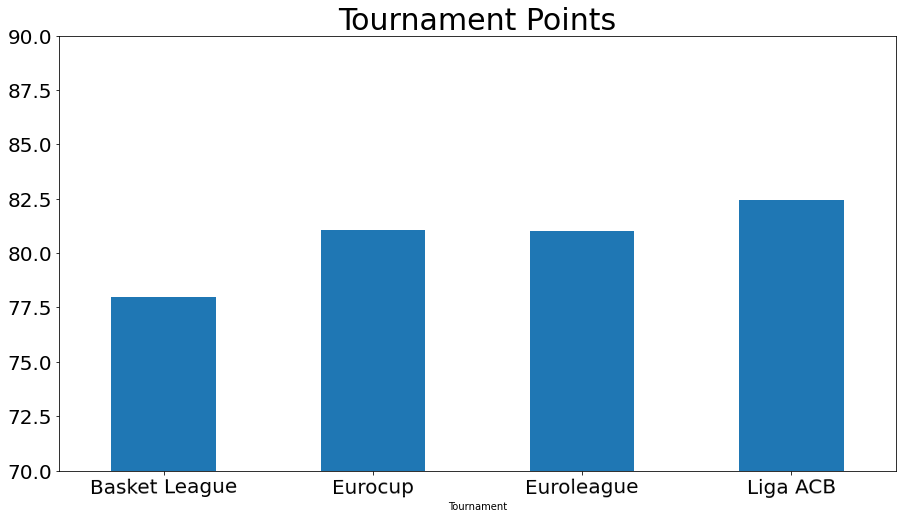

In [54]:
df_agg=final_teams2.groupby([final_teams2['Tournament']]).agg({"Team Points":"mean"})
g=df_agg["Team Points"].groupby(level=0, group_keys=False)
plt.figure(figsize=(15,8))
g.nlargest(1).plot.bar(x='Tournament', y="Team Points",rot=0.5,title="Tournament Points",fontsize=20)
plt.title("Tournament Points",fontsize=30)
plt.ylim(70,90)
plt.show()

In [55]:
df_agg=final_teams2.groupby([final_teams2['Tournament'],final_teams2['Home Team']]).agg({"teamEDiff":"mean"})
g=df_agg['teamEDiff'].groupby(level=0, group_keys=False)
g.nlargest(5)

Tournament     Home Team                    
Basket League  OLYMPIACOS B.C.                  22.110138
               PANATHINAIKOS B.C.               21.262031
               PERISTERI B.C.                    8.660782
               HOLARGOS B.C.                     7.899677
               AEK B.C.                          7.312548
Eurocup        ARIS B.C.                        16.814625
               PBC LOKOMOTIV KUBAN              15.352495
               KK CRVENA ZVEZDA                 15.142116
               FC BAYERN MUNICH (BASKETBALL)    15.092931
               BC KHIMKI                        14.035335
Euroleague     PBC CSKA MOSCOW                  12.657456
               FENERBAHÇE BASKETBALL             9.965989
               REAL MADRID BALONCESTO            9.754446
               BC NEPTŪNAS                       8.751840
               OLYMPIACOS B.C.                   7.381979
Liga ACB       FC BARCELONA BÀSQUET             15.323575
               REAL MADRID 

# Save the Data Frame 

In [56]:
final_teams2.to_csv('../data/crawling_preprocess_data.csv',sep = ',',index = None, header=True)